#### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob
import shutil

#### LSTM parameters

- n_signals: signals fed into model for each event (i.e. for input signals: [$I_{a}$, $I_{b}$, $I_{c}$] -> n_signals = 3).
- N: window size. For 3840Hz sampling frequency and a 0.016ms window (containing one cycle of a 60Hz wave), N = 64.
$$ N = fs/f_{fundamental}$$
- target_size
    - target_size = 1:
        - Binary Classification: One output treated as probability of belonging to one class or the other (E.g. No-Fault: 0 /Fault: 1)
    - target_size > 1:
        - Multiclass: Multiple exclusive classes. Class with higher score represents predicted class. The sum of scores (using softmax) always sums 1. (E.g. [No-fault, Fault, Caps], a output of values [0.07, 0.91, 0.2] represents a Fault class prediction)
        - Multilabel: Multiple classes that are not mutually exclusive.

In [2]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
target_size = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


#### Model Creation

(Hablar un poco de la arquitectura del modelo)

In [3]:
# Model Creation

class FaultDetector(nn.Module):
    """Some Information about FaultDetector"""
    def __init__(self, N, hidden_dim, target_size):
        super(FaultDetector, self).__init__()
        self.sequential = nn.Sequential(
            nn.LSTM(N, hidden_dim, batch_first=True),
            nn.Linear(hidden_dim, target_size)
        )
    def forward(self, x):
        z = self.sequential(x)
        return torch.sigmoid(z)

#### Dataset Class 

In [274]:
class CSVIndexExample(torch.utils.data.Dataset):
    """Some Information about CSVIndexExample"""

    def __init__(self, data_dir, window_len, max_window_idx=10):
        super(CSVIndexExample, self).__init__()
        self.csv_list = glob.glob(f"{data_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount
        self.max_window_idx = max_window_idx
        self.windows = np.arange(0, windows_amount, 1) % max_window_idx

    def __getitem__(self, index):
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        return window_idx, csv_idx, index

    def __len__(self):
        return self.csv_amount * self.max_window_idx


dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/"
csv_amount = 4
window_len = 64
max_window_idx = 2
windows_amount = max_window_idx * csv_amount
dataset = CSVIndexExample(dataset_dir, window_len, max_window_idx)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
dataiter = iter(train_dataloader)

for signal in dataiter:
    a, b, c = signal
    print(f"señal: {a}")
    print(f"signal idx: {b}")
    print(f"sample idx: {c}")


señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([0, 0, 1, 1, 2, 2, 3, 3])
sample idx: tensor([0, 1, 2, 3, 4, 5, 6, 7])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([4, 4, 5, 5, 6, 6, 7, 7])
sample idx: tensor([ 8,  9, 10, 11, 12, 13, 14, 15])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([ 8,  8,  9,  9, 10, 10, 11, 11])
sample idx: tensor([16, 17, 18, 19, 20, 21, 22, 23])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([12, 12, 13, 13, 14, 14, 15, 15])
sample idx: tensor([24, 25, 26, 27, 28, 29, 30, 31])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([16, 16, 17, 17, 18, 18, 19, 19])
sample idx: tensor([32, 33, 34, 35, 36, 37, 38, 39])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([20, 20, 21, 21, 22, 22, 23, 23])
sample idx: tensor([40, 41, 42, 43, 44, 45, 46, 47])
señal: tensor([0, 1, 0, 1, 0, 1, 0, 1])
signal idx: tensor([24, 24, 25, 25, 26, 26, 27, 27])
sample idx: tensor([48, 49, 50, 51, 52, 53, 54, 55])
se

In [276]:
class Form1Dataset(torch.utils.data.Dataset):
    """Some Information about Form1Dataset"""

    def __init__(self, dataset_dir, window_len=64, max_window_idx=193):
        super(Form1Dataset, self).__init__()
        self.max_window_idx = max_window_idx

        self.csv_list = glob.glob(f"{data_dir}*.csv")
        self.csv_amount = len(self.csv_list)
        self.windows_amount = max_window_idx * self.csv_amount

    def __getitem__(self, index):
        window_idx = index % self.max_window_idx
        csv_idx = index // self.max_window_idx
        csv_name = self.csv_list[index]
        return window_idx, csv_name, index

    def __len__(self):
        return self.csv_amount * self.max_window_idx


In [ ]:
max_window_idx = 193
dataset = CSVIndexExample(dataset_dir, max_window_idx)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
dataiter = iter(train_dataloader)

for signal in dataiter:
    a, b, c = signal
    print(f"señal: {a}")
    print(f"signal idx: {b}")
    print(f"sample idx: {c}")


256
193
0.0499968
0.0333312
32


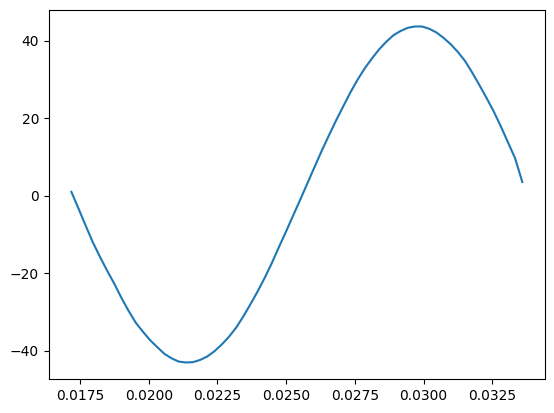

In [80]:
# Dataset Parameters
fs = 3840
N = 64
m = 2200
dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/"

from utils.signalload import CSV_pandas, CSV_pandas_path
import utils.plot_api as plt_api
signal_information = {}
signal_information["plots"] = {}
signal_information['window_length'] = 64
signal_information['step'] = 1
signal_information['signal_name'] = "I: X0023A-R1A"
signal_information['signals'] = CSV_pandas_path(f"{dataset_dir}Fault11_B860_RF100.csv")

t, signal, _, _ = plt_api.img_signal(signal_information)
# plt.plot(t, signal)

t_windows, signal_windows, _, _ = plt_api.anim_signal(signal_information)
print(len(signal))
print(len(t_windows))
print(t[192])
fault_window = len(t_windows)//2
print(t_windows[65][-1])
plt.plot(t_windows[66], signal_windows[66])


# plt.plot(t[: plot_len], signal[: plot_len])




print(65//2)

In [16]:
# get all file names in 


dataset_dir = "C:/Users/aherrada/OneDrive - Universidad del Norte/Uninorte/DetectionDataBase/LSTM_form_1/"
csv_list = glob.glob(f"{dataset_dir}*.csv")
print(os.path.basename(csv_list[0]))



Fault01_B124_RF100.csv
..\..\..\OneDrive - Universidad del Norte\Uninorte\DetectionDataBase\LSTM_form_1\Fault01_B124_RF100.csv
C:\Users\aherrada\OneDrive - Universidad del Norte\Uninorte\DetectionDataBase\LSTM_form_1\Fault01_B124_RF100.csv


In [21]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

In [ ]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

In [ ]:
# Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights.pth')
model.load_state_dict(torch.load('./models/LSTMHarmonic_weights.pth'))

In [ ]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.round(x))